# Investigating the Titanic passengers data set

<!-- PELICAN_BEGIN_SUMMARY -->

In this notebook we will explore the [Kaggle training dataset](https://www.kaggle.com/c/titanic/download/train.csv) to discover which factors influence Survival of a passenger on board the titanic.

<!-- PELICAN_END_SUMMARY -->

# Data Question: Which factors influence survival of a passenger?

First we'll setup the libraries we require and have a look at the data.

In [7]:
# Setup

# Data Processing
import pandas as pd
import numpy as np
import ipy_table as tbl # for tables

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns
# Using easy highcharts for interactive charts
import ezhc as hc
%matplotlib inline

# Regex
import re

# Maths
import math
import scipy
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

#Tells Jupyter to print results of any variable on a new line so tables will look good
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Check what was loaded
%load_ext version_information
%version_information pandas, ipython, jupyter, ezhc

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.1 64bit [MSC v.1900 64 bit (AMD64)]
IPython 6.1.0
OS Windows 10 10.0.16299 SP0
pandas 0.20.3
ipython 6.1.0
jupyter 1.0.0
ezhc 0.6.7
Mon Nov 20 14:40:19 2017 AUS Eastern Daylight Time

In [8]:
# Read the file and take a look
origdf = pd.read_csv("train.csv")
origdf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Details for all variables copied from Kaggle.

<h3> Data Dictionary </h3>
<table align="left">
<tbody>
<tr><th><b>Variable</b></th><th><b>Definition</b></th><th><b>Key</b></th></tr>
<tr>
<td>survival</td>
<td>Survival</td>
<td>0 = No, 1 = Yes</td>
</tr>
<tr>
<td>pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>sex</td>
<td>Sex</td>
<td></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td></td>
</tr>
<tr>
<td>sibsp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>ticket</td>
<td>Ticket number</td>
<td></td>
</tr>
<tr>
<td>fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td></td>
</tr>
<tr>
<td>embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

### Variable Notes
<p><b>pclass</b>: A proxy for socio-economic status (SES)<br> 1st = Upper<br> 2nd = Middle<br> 3rd = Lower<br><br> <b>age</b>: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br><br> <b>sibsp</b>: The dataset defines family relations in this way...<br> Sibling = brother, sister, stepbrother, stepsister<br> Spouse = husband, wife (mistresses and fiancés were ignored)<br><br> <b>parch</b>: The dataset defines family relations in this way...<br> Parent = mother, father<br> Child = daughter, son, stepdaughter, stepson<br> Some children travelled only with a nanny, therefore parch=0 for them.</p>

***

# Data Wrangling

Next step is to wrangle our data. Since we aren't searching for additional data we'll start with cleaning. We want fix missing values and any mistakes we find in the data.

In [9]:
# More looking at the data to get an idea of what we have
origdf.describe()
origdf.info()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


We see from the info() that there are missing values in Age, Cabin and Embarked as the count is lower than 891.

In [10]:
# A clearer way to check for missing (null) values
origdf.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [11]:
# Use any(axis=1) to return the rows with missing values
origdf[origdf.isnull().any(axis=1)].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S


### Planning our modifications
We find that Age, Cabin and Embarked have missing values. Cabin and Embarked are not items that we can imply so we'll just leave them be. I was thinking if there were missing values in 'Sex' we could possibly imply a person's gender from their name.

For brevity I'm only going to be exploring the following attributes and their affect on Survival.
- Ticket Class
- Gender
- Age Groups
- Fare Paid
- Embarking Port

#### Next steps

- PassengerId: Set as our index 
- Survived: Create column Survival with easier to read labels, Died and Survived. Also keeping Survived for graphing later
- Sex: Rename to Gender
- Age: Fill missing values with median age. Create Age Groups
- Embarked: Rename column to EmbarkingPort. Create easier to read labels (full names of ports), fill missing values with Unknown.
- Pclass: Rename column to Class. Create easier to read labels, First, Second and Third Class
- Fare: Rename column to FarePaid
- DROP all other rows we won't be using 

In [12]:
# Creating a new dataframe and leaving the original intact in case we need it
df = origdf.set_index('PassengerId')

In [13]:
# Create easier to read survival columnn
df['Survival'] = df.Survived.map({0 : 'Died', 1 : 'Survived'}).astype('object')
df['Survival'] = df['Survival'].astype(object)

In [14]:
# Rename Fare and Sex columns
df = df.rename(columns={'Fare':'FarePaid','Sex':'Gender'})

In [15]:
# Capitalise for consistency
df['Gender'] = df.Gender.map({'female' : 'Female', 'male' : 'Male'}).astype('object')

In [16]:
# Fill in missing values for Age as the median age
df['Age'].fillna(df['Age'].median(),inplace=True)
df['Age'] = df['Age'].astype(int)

In [17]:
# Check null values for Embarked
# The opposite: origdf[origdf.Embarked.notnull()]
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Gender,Age,SibSp,Parch,Ticket,FarePaid,Cabin,Embarked,Survival
PassengerId,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",Female,38,0,0,113572,80.0,B28,NaN,Survived
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",Female,62,0,0,113572,80.0,B28,NaN,Survived


In [18]:
# Replace missing values with 0 and Create easier to read Ports column for where someone embarked
df['Embarked'].fillna(0,inplace=True)
df['EmbarkingPort'] = df.Embarked.map({'C' : 'Cherbourg', 'Q' : 'Queenstown', 
                                       'S' : 'Southampton', 0 : 'Unknown'}).astype('object')

In [19]:
# Create easier to read Class column
df['Class'] = df.Pclass.map({1 : 'First Class', 2 : 'Second Class', 3 : 'Third Class'}).astype('object')

In [20]:
# Dropping variables we won't be using
df.drop(['Name','Pclass','SibSp','Parch','Cabin','Ticket','Embarked'], 
        axis=1, inplace=True)

In [21]:
# Reorder columns
df = df[['Survival','Gender','Age','EmbarkingPort','Class','FarePaid','Survived']]

In [22]:
# Checking our data is now cleaned
df.head()
df.info()

,Survival,Gender,Age,EmbarkingPort,Class,FarePaid,Survived
PassengerId,,,,,,,
1,Died,Male,22,Southampton,Third Class,7.2500,0
2,Survived,Female,38,Cherbourg,First Class,71.2833,1
3,Survived,Female,26,Southampton,Third Class,7.9250,1
4,Survived,Female,35,Southampton,First Class,53.1000,1
5,Died,Male,35,Southampton,Third Class,8.0500,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
Survival         891 non-null object
Gender           891 non-null object
Age              891 non-null int32
EmbarkingPort    891 non-null object
Class            891 non-null object
FarePaid         891 non-null float64
Survived         891 non-null int64
dtypes: float64(1), int32(1), int64(1), object(4)
memory usage: 52.2+ KB


In [23]:
# Double check for missing values
df.isnull().any()

Survival         False
Gender           False
Age              False
EmbarkingPort    False
Class            False
FarePaid         False
Survived         False
dtype: bool

***

# Data Exploration
### Visualising at our variables

Here we'll get a better idea of what our data looks like.

In [24]:
# Percentage Survival. c for counts
cSurvival = pd.DataFrame(df['Survival'].value_counts())

g = hc.Highcharts()

g.chart.type = 'pie'
g.chart.width = 500
g.chart.height = 500
g.tooltip.headerFormat = '<b>{point.key}</b><br>'
g.tooltip.pointFormat= '<b>{point.percentage:.1f}%</b> <br>{point.y} of 891'
gpo = g.plotOptions.pie
gpo.showInLegend = False
gpo.dataLabels.enabled = True
gpo.dataLabels.distance = 0
gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'
gpo.colors = ['black','green']

g.title.text = 'Survival Percentage'
g.series = hc.build.series(cSurvival)

g.plot()

In [25]:
# Gender distribution.
cGender = pd.DataFrame(df['Gender'].value_counts())

g = hc.Highcharts()

g.chart.type = 'pie'
g.chart.width = 480
g.chart.height = 480
g.tooltip.headerFormat = '<b>{point.key}</b><br>'
g.tooltip.pointFormat = '<b>{point.percentage:.1f}%</b> <br>{point.y} of 891'
gpo = g.plotOptions.pie
gpo.showInLegend = True
gpo.dataLabels.enabled = True
gpo.dataLabels.distance = 0
gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'
gpo.colors = ['#434DF2','#F37161'] #blue for male, red for female

g.title.text = 'Men and women on board'
g.series = hc.build.series(cGender)

g.plot()

In [26]:
# Age Distribution. 
cAge = pd.DataFrame(df['Age'].value_counts())

g = hc.Highcharts()

g.chart.type = 'column'
g.yAxis.title.text = '<b>Frequency</b>'
g.xAxis.title.text = '<b>Age</b>'
g.tooltip.headerFormat = ''
g.tooltip.pointFormat = 'Age {point.x}: {point.y}'
gpo = g.plotOptions.column
gpo.groupPadding = 0
gpo.pointPadding = 0
gpo.borderWidth = 0.5
gpo.showInLegend = False

g.title.text = 'Age Distribution'
g.series = hc.build.series(cAge)

g.plot()

Note that since our missing age values were replaced with the median age of 28,  we have a large spike of 28 year olds on board which is likely not to be true.

In [27]:
# Percentage division of ports
cEmbarkingPort = pd.DataFrame(df['EmbarkingPort'].value_counts())

g = hc.Highcharts()

g.chart.type = 'pie'
g.chart.width = 550
g.chart.height = 550
g.tooltip.headerFormat = '<b>{point.key}</b><br>'
g.tooltip.pointFormat= '<b>{point.percentage:.1f}%</b> <br>{point.y} of 891'
gpo = g.plotOptions.pie
gpo.showInLegend = False
gpo.dataLabels.enabled = True
gpo.dataLabels.distance = 10
gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'

g.title.text = 'Embarking from the following locations'
g.series = hc.build.series(cEmbarkingPort)

g.plot()

In [28]:
# Percentage division of Ticket Class
cClass = pd.DataFrame(df['Class'].value_counts())

g = hc.Highcharts()

g.chart.type = 'pie'
g.chart.width = 550
g.chart.height = 550
g.tooltip.headerFormat = '<b>{point.key}</b><br>'
g.tooltip.pointFormat= '<b>{point.percentage:.1f}%</b> <br>{point.y} of 891'
gpo = g.plotOptions.pie
gpo.showInLegend = False
gpo.dataLabels.enabled = True
gpo.dataLabels.distance = 0
gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'
gpo.colors = ['#B6B6B6','#434DF2','#EC4242']

g.title.text = 'Ticket Class distribution'
g.series = hc.build.series(cClass)

g.plot()

In [29]:
# Fare Paid Distribution. 
cFarePaid = pd.DataFrame(df['FarePaid'].value_counts())

g = hc.Highcharts()

g.chart.type = 'column'
g.yAxis.title.text = '<b>Frequency</b>'
g.xAxis.title.text = '<b>Fare Paid for a ticket</b>'
g.tooltip.headerFormat = ''
g.tooltip.pointFormat = 'Fare Paid £{point.x:.2f}, Frequency {point.y}'
gpo = g.plotOptions.column
gpo.groupPadding = 0
gpo.pointPadding = 0
gpo.borderWidth = 0.5
gpo.showInLegend = False

g.title.text = 'Fare Paid'
g.series = hc.build.series(cFarePaid)

g.plot()

Now that we have visualised our data we can run the appropriate tests to determine how our variables impact Survival.

***

## Choosing a statistical test
We'll explore statistical significance/association and strength of association in the order the variables are shown below.

In [30]:
# Since the below table is created using a spreadsheet then converted to HTML
# add in align="left" next to <table

<table align="left" dir="ltr" style="float: left; width: 653px;" border="1" cellspacing="0" cellpadding="0"><colgroup><col width="145" /><col width="153" /><col width="164" /><col width="168" /></colgroup>
<tbody>
<tr>
<td style="text-align: left; width: 188px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Independent Variable&quot;}"><strong>Independent Variable</strong></td>
<td style="text-align: left; width: 172px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Dependent Variable&quot;}"><strong>Dependent Variable</strong></td>
<td style="text-align: left; width: 64px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Test&quot;}"><strong>Test</strong></td>
<td style="text-align: left; width: 228px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Confirming Strength of Test&quot;}"><strong>Confirming Strength of Test</strong></td>
</tr>
<tr>
<td style="text-align: left; width: 188px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Gender (Categorical)&quot;}">Gender (Categorical)</td>
<td style="text-align: left; width: 172px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Survival (Categorical)&quot;}">Survival (Categorical)</td>
<td style="text-align: left; width: 64px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Chi-square&quot;}">Chi-square</td>
<td style="text-align: left; width: 228px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Cramer's V&quot;}">Cramer's V</td>
</tr>
<tr>
<td style="text-align: left; width: 188px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Age Groups (Interval)&quot;}">Age Groups (Interval)</td>
<td style="text-align: left; width: 172px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Survival (Categorical)&quot;}">Survival (Categorical)</td>
<td style="text-align: left; width: 64px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Chi-square&quot;}">Chi-square</td>
<td style="text-align: left; width: 228px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Cramer's V&quot;}">Cramer's V</td>
</tr>
<tr>
<td style="text-align: left; width: 188px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Ports (Categorical)&quot;}">Ports (Categorical)</td>
<td style="text-align: left; width: 172px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Survival (Categorical)&quot;}">Survival (Categorical)</td>
<td style="text-align: left; width: 64px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Chi-square&quot;}">Chi-square</td>
<td style="text-align: left; width: 228px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Cramer's V&quot;}">Cramer's V</td>
</tr>
<tr>
<td style="text-align: left; width: 188px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Class (Ordinal)&quot;}">Class (Ordinal)</td>
<td style="text-align: left; width: 172px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Survival (Categorical)&quot;}">Survival (Categorical)</td>
<td style="text-align: left; width: 64px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Chi-square&quot;}">Chi-square</td>
<td style="text-align: left; width: 228px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Cramer's V&quot;}">Cramer's V</td>
</tr>
<tr>
<td style="text-align: left; width: 188px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Fare Paid (Normal)&quot;}">Fare Paid (Normal)</td>
<td style="text-align: left; width: 172px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Survival (Categorical)&quot;}">Survival (Categorical)</td>
<td style="text-align: left; width: 64px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Logistic Regression&quot;}">Logistic Regression</td>
<td style="text-align: left; width: 228px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;ROC AUC&quot;}">F1 Score</td>
</tr>
</tbody>
</table>

I refer to NYU's [guide](https://guides.nyu.edu/quant/choose_test_1DV) to choosing a statistical test for 1 dependent variable to confirm which statistical tests to use. As well as my Udacity Reviewer's suggestions.

***

### Testing Gender
Our hypotheses (expectations) are as follows:

$H_{0}$: Gender and Survival are independent. That is Gender has no affect on Survival. Our null hypothesis.

$H_{a}$: Gender and Survival are not independent. That is Gender has an affect on Surival. Alternate hypothesis.

Using our Chi-square test we have the following assumptions:
- Significance level = 0.05 = p-value. This means we will be 95% sure of the result we attain.
- Degrees of freedom = 1. Since we have 2 parameters (female or male), we have <br>Degrees of freedom = Parameters - 1

In [31]:
# Show our contingency table aka crosstabulation
# The first variable is the one that is totaled
# ctGender = df[['Gender','Survival']].groupby(['Gender','Survival']).size().unstack(1)
# both methods work then output (rows,cols)
ctGender = pd.crosstab(df.Gender,df.Survival)
ctGender

Survival,Died,Survived
Gender,,
Female,81,233
Male,468,109


The result becomes clearer once visualised.

In [32]:
# Survival by Gender visualised.
g = hc.Highcharts()

g.chart.type = 'column'
g.yAxis.title.text = '<b>Percentage</b>'
g.yAxis.labels.format = '{value}%'
g.xAxis.title.text = '<b>Gender</b>'
g.xAxis.categories = list(ctGender.index)
# g.chart.height = 400
# g.tooltip.headerFormat = '<b>{series.index}</b><br>'
g.tooltip.headerFormat = ''
# g.tooltip.pointFormat = 'Ticket Number {point.x}, Frequency {point.y}'
g.tooltip.pointFormat = '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.percentage:.1f}%)<br/>'
g.tooltip.shared = 'True'
gpo = g.plotOptions.column
gpo.stacking = 'percent'
gpo.showInLegend = True
# gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'


g.title.text = 'Survival by Gender'
g.series = hc.build.series(ctGender, color={'Died': 'black', 'Survived': 'green'})


g.plot()

Here we find ~74% of women survived while ~19% of men survived.

In [33]:
# Use Pearson's chi-squared test
chi2,p,dof,ex = scipy.stats.chi2_contingency(ctGender)
results = [['Item','Value'],
           ['Chi-Square Test',chi2],
           ['p-value', p],
           ['Degrees of freedom',dof]]
# setting up a nicer looking table.
tbl.make_table(results)
tbl.set_row_style(0, bold=True)
tbl.set_row_style(2,float_format='%0.3E');

In [34]:
tbl.render()

Item,Value
Chi-Square Test,260.7170
p-value,1.197E-58
Degrees of freedom,1


We check our Chi-squared distribution and find if our chi2 ($\chi^{2}$) statistic exceeds our critical value. From the table below we see our critical value is
<br>p-value = 0.05
<br>degrees of freedom = 1
<br>critical value = 3.841

I have also highlighted the critical values we will be using for our other parameters.

### Chi-squared table
<table align="left" dir="ltr" style="width: 398px;" border="1" cellspacing="0" cellpadding="0"><colgroup><col width="100" /><col width="100" /><col width="100" /><col width="100" /><col width="100" /><col width="100" /></colgroup>
<tbody>
<tr style="height: 21px;">
<td style="text-align: left; width: 10px; height: 21px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;DF / P&quot;}"><strong>DF / P</strong></td>
<td style="text-align: left; width: 27px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:0.1}"><strong>0.1</strong></td>
<td style="text-align: left; width: 101px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:0.05}"><strong>0.05</strong></td>
<td style="text-align: left; width: 95px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:0.025}"><strong>0.025</strong></td>
<td style="text-align: left; width: 70px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:0.02}"><strong>0.02</strong></td>
<td style="text-align: left; width: 94px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:0.01}"><strong>0.01</strong></td>
</tr>
<tr style="height: 21px;">
<td style="text-align: left; width: 10px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:1}"><strong>1</strong></td>
<td style="text-align: left; width: 27px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:2.706}">2.706</td>
<td style="width: 101px; height: 21px; background-color: #f3f94b; text-align: left;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:3.841}">3.841</td>
<td style="text-align: left; width: 95px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:5.024}">5.024</td>
<td style="text-align: left; width: 70px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:5.412}">5.412</td>
<td style="text-align: left; width: 94px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:6.635}">6.635</td>
</tr>
<tr style="height: 21px;">
<td style="text-align: left; width: 10px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:2}"><strong>2</strong></td>
<td style="text-align: left; width: 27px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:4.605}">4.605</td>
<td style="width: 101px; height: 21px; background-color: #f3f94b; text-align: left;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:5.991}">5.991</td>
<td style="text-align: left; width: 95px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:7.378}">7.378</td>
<td style="text-align: left; width: 70px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:7.824}">7.824</td>
<td style="text-align: left; width: 94px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:9.21}">9.21</td>
</tr>
<tr style="height: 21px;">
<td style="text-align: left; width: 10px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:3}"><strong>3</strong></td>
<td style="text-align: left; width: 27px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:6.251}">6.251</td>
<td style="width: 101px; height: 21px; background-color: #f3f94b; text-align: left;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:7.815}">7.815</td>
<td style="text-align: left; width: 95px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:9.348}">9.348</td>
<td style="text-align: left; width: 70px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:9.837}">9.837</td>
<td style="text-align: left; width: 94px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:11.345}">11.345</td>
</tr>
<tr style="height: 21px;">
<td style="text-align: left; width: 10px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:4}"><strong>4</strong></td>
<td style="text-align: left; width: 27px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:7.779}">7.779</td>
<td style="text-align: left; width: 101px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:9.488}">9.488</td>
<td style="text-align: left; width: 95px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:11.143}">11.143</td>
<td style="text-align: left; width: 70px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:11.668}">11.668</td>
<td style="text-align: left; width: 94px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:13.277}">13.277</td>
</tr>
<tr style="height: 21px;">
<td style="text-align: left; width: 10px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:5}"><strong>5</strong></td>
<td style="text-align: left; width: 27px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:9.236}">9.236</td>
<td style="text-align: left; width: 101px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:11.07}">11.07</td>
<td style="text-align: left; width: 95px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:12.833}">12.833</td>
<td style="text-align: left; width: 70px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:13.388}">13.388</td>
<td style="text-align: left; width: 94px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:15.086}">15.086</td>
</tr>
<tr style="height: 21px;">
<td style="text-align: left; width: 10px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:6}"><strong>6</strong></td>
<td style="text-align: left; width: 27px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:10.645}">10.645</td>
<td style="text-align: left; width: 101px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:12.592}">12.592</td>
<td style="text-align: left; width: 95px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:14.449}">14.449</td>
<td style="text-align: left; width: 70px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:15.033}">15.033</td>
<td style="text-align: left; width: 94px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:16.812}">16.812</td>
</tr>
<tr style="height: 21px;">
<td style="text-align: left; width: 10px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:7}"><strong>7</strong></td>
<td style="text-align: left; width: 27px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:12.017}">12.017</td>
<td style="width: 101px; height: 21px; background-color: #f3f94b; text-align: left;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:14.067}">14.067</td>
<td style="text-align: left; width: 95px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:16.013}">16.013</td>
<td style="text-align: left; width: 70px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:16.622}">16.622</td>
<td style="text-align: left; width: 94px; height: 21px;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:18.475}">18.475</td>
</tr>
</tbody>
</table>

Our result $\chi^{2}\approx260 > 3.841$

With a p-value $< 0.05$
We have a statistically significant value here. Thus we reject $H_{0}$ in favour of $H_{a}$, that Gender affects Survival.

We'll now use Cramer's V to check the strength of this association with reference to the table below.

### Cramer's V table
<table dir="ltr" style="width: 565px; float: left;" border="1" cellspacing="0" cellpadding="0"><colgroup><col width="60" /><col width="65" /><col width="169" /></colgroup>
<tbody>
<tr style="height: 41px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;LEVEL OF ASSOCIATION&quot;}"><strong>Cramer's V 
Result</strong></td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Verbal Description&quot;}"><strong>Verbal Description</strong></td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;COMMENTS&quot;}"><strong>Comments</strong></td>
</tr>
<tr style="height: 41px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:0}">0</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;No Relationship&quot;}">No Relationship</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Knowing the independent variable does not help in predicting the dependent variable.&quot;}">
<div>
<div>Knowing the independent variable does not help in predicting the dependent variable.</div>
</div>
</td>
</tr>
<tr style="height: 21px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;.00 to .15&quot;}">.00 to .15</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Very Weak&quot;}">Very Weak</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Not generally acceptable&quot;}">Not generally acceptable</td>
</tr>
<tr style="height: 21px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;.15 to .20&quot;}">.15 to .20</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Weak&quot;}">Weak</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Minimally acceptable&quot;}">Minimally acceptable</td>
</tr>
<tr style="height: 21px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;.20 to .25&quot;}">.20 to .25</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Moderate&quot;}">Moderate</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Acceptable&quot;}">Acceptable</td>
</tr>
<tr style="height: 21px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;.25 to .30&quot;}">.25 to .30</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Moderately Strong&quot;}">Moderately Strong</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Desirable&quot;}">Desirable</td>
</tr>
<tr style="height: 21px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;.30 to .35&quot;}">.30 to .35</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Strong&quot;}">Strong</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Very Desirable&quot;}">Very Desirable</td>
</tr>
<tr style="height: 21px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;.35 to .40&quot;}">.35 to .40</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Very Strong&quot;}">Very Strong</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Extremely Desirable&quot;}">Extremely Desirable</td>
</tr>
<tr style="height: 41px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;.40 to .50&quot;}">.40 to .50</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Worrisomely Strong&quot;}">Worrisomely Strong</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Either an extremely good relationship or the two variables are measuring the same concept&quot;}">
<div>
<div>Either an extremely good relationship or the two variables are measuring the same concept</div>
</div>
</td>
</tr>
<tr style="height: 21px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;.50 to .99&quot;}">.50 to .99</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Redundant&quot;}">Redundant</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;The two variables are probably measuring the same concept.&quot;}">
<div>
<div>The two variables are probably measuring the same concept.</div>
</div>
</td>
</tr>
<tr style="height: 41px;">
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:3,&quot;3&quot;:1}">1</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Perfect Relationship.&quot;}">Perfect Relationship</td>
<td style="width: 22px; height: 41px; text-align: left;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;If we the know the independent variable, we can perfectly predict the dependent variable.&quot;}">
<div>
<div>If we the know the independent variable, we can perfectly predict the dependent variable.</div>
</div>
</td>
</tr>
</tbody>
</table>

In [35]:
# Defining Cramer's V since I couldn't find a library which had it
def cramersV(N,nrows,ncols,chi2):
    V = math.sqrt(chi2/(N*min(nrows-1,ncols-1)))
    return V

In [36]:
print('Cramer\'s V =',cramersV(len(df),len(ctGender.index),len(ctGender.columns),chi2)) 

Cramer's V = 0.5409359434469282


Using our table we see there is a "Redundant"(ly) strong relationship between Gender and Survival. Despite the description we know that gender and survival are not the same concept.

Hence we reject $H_{0}$ in favour of $H_{a}$.
<br>**We find Gender is statistically significant and a very strong predictor of Survival.**

***

### Testing Age
Our hypotheses (expectations) are as follows:

$H_{0}$: Age and Survival are independent.

$H_{a}$: Age and Survival are not independent.

Using the Chi-square test, we have the following assumptions:
- Significance level = 0.05 = p-value.
- Age will be binned into 8 groups with 10 year intervals
- Degrees of freedom = 7 (8 bins - 1)

In [37]:
# Create bins and two new columns, AgeGroup
bins = list(range(0,81,10))
bins[8] = 81
AgeGroups = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-80']
df['AgeGroup'] = pd.cut(df.Age, bins, right=False, labels=AgeGroups).astype('object')

In [38]:
# Create our contingency table
ctAge = pd.crosstab(df.AgeGroup,df.Survival)
ctAge

Survival,Died,Survived
AgeGroup,,
0-9,24,38
10-19,61,41
20-29,268,129
30-39,94,73
40-49,55,34
50-59,28,20
60-69,13,6
70-80,6,1


Charting the frequency then percentages of Survival by Age Group.

In [39]:
# Age bins visualised
g = hc.Highcharts()

g.chart.type = 'column'
g.yAxis.title.text = '<b>Frequency</b>'
g.xAxis.title.text = '<b>Age Groups</b>'
g.xAxis.categories = list(ctAge.index)
# g.chart.height = 400
# g.tooltip.headerFormat = '<b>{series.name}</b><br>'
g.tooltip.headerFormat = ''
# g.tooltip.pointFormat = 'Ticket Number {point.x}, Frequency {point.y}'
gpo = g.plotOptions.column
# gpo.groupPadding = 0
# gpo.pointPadding = 0
# gpo.borderWidth = 1
gpo.showInLegend = True
g.tooltip.shared = 'True'
# gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'

# gpo.colors = ['#058DC7', '#50B432']
# gpo.colorByPoint = True
# g.plotOptions.series.colorByPoint = True


g.title.text = 'Survival by Age Group'
g.series = hc.build.series(ctAge, color={'Died': 'black', 'Survived': 'green'})


g.plot()

In [40]:
# Age bins by percentage
g = hc.Highcharts()

g.chart.type = 'column'
g.yAxis.title.text = '<b>Percentage</b>'
g.yAxis.labels.format = '{value}%'
g.xAxis.title.text = '<b>Age Groups</b>'
g.xAxis.categories = list(ctAge.index)
# g.chart.height = 400
# g.tooltip.headerFormat = '<b>{series.index}</b><br>'
g.tooltip.headerFormat = ''
# g.tooltip.pointFormat = 'Ticket Number {point.x}, Frequency {point.y}'
g.tooltip.pointFormat = '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.percentage:.1f}%)<br/>'
g.tooltip.shared = 'True'
gpo = g.plotOptions.column
gpo.stacking = 'percent'
gpo.showInLegend = True
# gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'

# gpo.colors = ['#058DC7', '#50B432']
# gpo.colorByPoint = True
# g.plotOptions.series.colorByPoint = True


g.title.text = 'Survival by Age Group'
g.series = hc.build.series(ctAge, color={'Died': 'black', 'Survived': 'green'})


g.plot()

At a glance we see that a large proportion of children (ages 0-9) survived (61%) and a low proportion of elderly (ages 70-80) survived (14%). In the middle we have 10-69 year olds who survived 25-50% of the time.

Note that missing values in the Age column were replaced with the median age which was 28, so there will be some error in this result.

In [41]:
# Use Pearson's chi-squared test
chi2,p,dof,ex = scipy.stats.chi2_contingency(ctAge)
cV = cramersV(len(df),len(ctAge.index),len(ctAge.columns),chi2)
results = [['Item','Value'],
           ['Chi-Square Test',chi2],
           ['P-Value', p],
           ['Degrees of freedom',dof],
           ['',''],
           ['Cramer\'s V',cV]]
# setting up a nicer looking table.
tbl.make_table(results)
tbl.set_row_style(0, bold=True);
# tbl.set_row_style(2,float_format='%0.3E');

In [42]:
tbl.render()

Item,Value
Chi-Square Test,24.0363
P-Value,0.0011
Degrees of freedom,7
,
Cramer's V,0.1642


With 7 degrees of freedom and a p-value of 0.05 we have $\chi^{2}$ critical value of 14.067.

Our result $\chi^{2}\approx24 > 14.067$

With a p-value $< 0.05$
We have a statistically significant value. 

A Cramer's V of $\approx 0.16$ is described as weak and minimally acceptable relationship between Age and Survival.

Hence we reject $H_{0}$ in favour of $H_{a}$.
<br>**We find that Age is statistically significant with weak association to Survival.**

## Combining Gender and AgeGroup

By combining Gender and AgeGroup we discover another interesting insight.

In [43]:
# Grouping all 3
ctGenderAge = df[['Gender','AgeGroup','Survival']].groupby(['Gender','AgeGroup','Survival']).size().unstack(fill_value=0)
ctGenderAge

Survival         Died  Survived
Gender AgeGroup                
Female 0-9         11        19
       10-19       11        34
       20-29       37        88
       30-39       10        50
       40-49       10        22
       50-59        2        16
       60-69        0         4
Male   0-9         13        19
       10-19       50         7
       20-29      231        41
       30-39       84        23
       40-49       45        12
       50-59       26         4
       60-69       13         2
       70-80        6         1

In [44]:
# Gender and Age combined. will try workout highlightin the column later
g = hc.Highcharts()

g.chart.type = 'column'
g.yAxis.title.text = '<b>Frequency</b>'
g.yAxis.labels.format = '{value}%'
g.xAxis.title.text = '<b>Age Groups</b>'
g.xAxis.categories = list(ctGenderAge.index)
# g.chart.height = 400
# g.tooltip.headerFormat = '<b>{series.name}</b><br>'
g.tooltip.headerFormat = ''
# g.tooltip.pointFormat = 'Ticket Number {point.x}, Frequency {point.y}'
g.tooltip.pointFormat = '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.percentage:.1f}%)<br/>'
gpo = g.plotOptions.column
# gpo.groupPadding = 0
# gpo.pointPadding = 0
# gpo.borderWidth = 1
gpo.showInLegend = True
g.tooltip.shared = 'True'
# gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'
gpo.stacking = 'percent'



g.title.text = 'Survival by Age Group'
g.series = hc.build.series(ctGenderAge, color={'Died': 'black', 'Survived': 'green'})


g.plot()

Notice how most women survive in all age groups and most men die in most age groups. However males between 0-9 years of are surviving ~60% of the time. The cliche of "women and children first" seems to hold true.

***

### Testing Embarking Port

Our hypothesis:

$H_{0}$: Embarking Port and Survival are independent.

$H_{a}$: Embarking Port and Survival are not independent.

Using the Chi-square test, we have the following assumptions:
- Significance level = 0.05 = p-value.
- Degrees of freedom = 3 (4 ports - 1)

In [45]:
# Selecting only the Ticket Class and Survival while counting in each size group
ctEmbarkingPort = df[['EmbarkingPort','Survival']].groupby(['EmbarkingPort','Survival']).size().unstack(fill_value=0)
ctEmbarkingPort

Survival,Died,Survived
EmbarkingPort,,
Cherbourg,75,93
Queenstown,47,30
Southampton,427,217
Unknown,0,2


In [46]:
# Embarking Ports visualised.
g = hc.Highcharts()

g.chart.type = 'column'
g.yAxis.title.text = '<b>Percentage</b>'
g.yAxis.labels.format = '{value}%'
g.xAxis.title.text = '<b>Embarking Ports</b>'
g.xAxis.categories = list(ctEmbarkingPort.index)
# g.chart.height = 400
# g.tooltip.headerFormat = '<b>{series.name}</b><br>'
g.tooltip.headerFormat = ''
# g.tooltip.pointFormat = '<b>{series.name}</b>: {point.percentage:.1f}%'
g.tooltip.pointFormat = '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.percentage:.1f}%)<br/>'
g.tooltip.shared = 'True'
gpo = g.plotOptions.column
gpo.stacking = 'percent'
# gpo.pointPadding = 0
# gpo.borderWidth = 1
gpo.showInLegend = True
# gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'

# gpo.colors = ['#058DC7', '#50B432', '#33333']
# gpo.colorByPoint = True
# g.plotOptions.series.colorByPoint = True


g.title.text = 'Survival by Embarking Ports'
g.series = hc.build.series(ctEmbarkingPort, color={'Died': 'black', 'Survived': 'green'})


g.plot()

In [47]:
# Use Pearson's chi-squared test
chi2,p,dof,ex = scipy.stats.chi2_contingency(ctEmbarkingPort)
cV = cramersV(len(df),len(ctEmbarkingPort.index),len(ctEmbarkingPort.columns),chi2)
results = [['Item','Value'],
           ['Chi-Square Test',chi2],
           ['P-Value', p],
           ['Degrees of freedom',dof],
           ['',''],
           ['Cramer\'s V',cV]]
# setting up a nicer looking table.
tbl.make_table(results)
tbl.set_row_style(0, bold=True);
tbl.set_row_style(2,float_format='%0.3E');

In [48]:
tbl.render()

Item,Value
Chi-Square Test,29.6706
P-Value,1.619E-06
Degrees of freedom,3
,
Cramer's V,0.1825


With 3 degrees of freedom and a p-value of 0.05 we have $\chi^{2}$ critical value of 7.815.

Our result $\chi^{2}\approx30 > 7.815$

With a p-value $< 0.05$
We have a statistically significant value. 

A Cramer's V of $\approx 0.18$ is described as weak and minimally acceptable relationship between Embarking Port and Survival.

Hence we reject $H_{0}$ in favour of $H_{a}$.
<br>**We find that Embarking Port is statistically significant with weak association to Survival.**

***

### Testing Ticket Class

Our hypothesis:

$H_{0}$: Ticket Class and Survival are independent.

$H_{a}$: Ticket CLass and Survival are not independent.

Using the Chi-square test, we have the following assumptions:
- Significance level = 0.05 = p-value.
- Degrees of freedom = 2 (3 classes - 1)

In [49]:
# Selecting only the Ticket Class and Survival while counting in each size group
ctClass = df[['Class','Survival']].groupby(['Class','Survival']).size().unstack()
ctClass

Survival,Died,Survived
Class,,
First Class,80,136
Second Class,97,87
Third Class,372,119


In [50]:
# Ticket Class visualised.
g = hc.Highcharts()

g.chart.type = 'column'
g.yAxis.title.text = '<b>Percentage</b>'
g.yAxis.labels.format = '{value}%'
g.xAxis.title.text = '<b>Ticket Class</b>'
g.xAxis.categories = list(ctClass.index)
# g.chart.height = 400
# g.tooltip.headerFormat = '<b>{series.name}</b><br>'
g.tooltip.headerFormat = ''
# g.tooltip.pointFormat = '<b>{series.name}</b>: {point.percentage:.1f}%'
g.tooltip.pointFormat = '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.percentage:.1f}%)<br/>'
g.tooltip.shared = 'True'
gpo = g.plotOptions.column
gpo.stacking = 'percent'
# gpo.pointPadding = 0
# gpo.borderWidth = 1
gpo.showInLegend = True
# gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'

# gpo.colors = ['#058DC7', '#50B432', '#33333']
# gpo.colorByPoint = True
# g.plotOptions.series.colorByPoint = True


g.title.text = 'Survival by Ticket Class'
g.series = hc.build.series(ctClass, color={'Died': 'black', 'Survived': 'green'})


g.plot()

We see a clear decline in Survival with decline in Ticket Class. Survival for First Class is 63%, Second Class is 47.3% and Third Class is 24.2%.

In [51]:
# Use Pearson's chi-squared test
chi2,p,dof,ex = scipy.stats.chi2_contingency(ctClass)
cV = cramersV(len(df),len(ctClass.index),len(ctClass.columns),chi2)
results = [['Item','Value'],
           ['Chi-Square Test',chi2],
           ['P-Value', p],
           ['Degrees of freedom',dof],
           ['',''],
           ['Cramer\'s V',cV]]
# setting up a nicer looking table.
tbl.make_table(results)
tbl.set_row_style(0, bold=True);
tbl.set_row_style(2,float_format='%0.3E');

In [52]:
tbl.render()

Item,Value
Chi-Square Test,102.8890
P-Value,4.549E-23
Degrees of freedom,2
,
Cramer's V,0.3398


With 2 degrees of freedom and a p-value of 0.05 we have $\chi^{2}$ critical value of 5.991.

Our result $\chi^{2}\approx103 > 5.991$

With a p-value $< 0.05$
We have a statistically significant value. 

A Cramer's V of $\approx 0.33$ is described as strong and very desirable relationship between Ticket Class and Survival.

Hence we reject $H_{0}$ in favour of $H_{a}$.
<br>**We find that Ticket Class is statistically significant with strong association to Survival.**

***

### Testing Fare Paid

We use Logistic Regression to test if the fare paid for a ticket is a good indicator of survival. A logistic regression is typically used as a predictive model, but in our case we will use it measure the determine how good a predictor Fare Paid is on Survival. Our metric for measurement will be the F1-Score.

In [53]:
# Selecting only the Ticket Class and Survival while counting in each size group
ctFarePaid = df[['FarePaid','Survival']].groupby(['FarePaid','Survival']).size().unstack()#(fill_value=0)
ctFarePaid.head()

Survival,Died,Survived
FarePaid,,
0.0000,14.0,1.0
4.0125,1.0,NaN
5.0000,1.0,NaN
6.2375,1.0,NaN
6.4375,1.0,NaN


This contingency table is not grouped so there are many values, above are only the first 5.

In [54]:
# Scatter of Fare Paid vs Survival
g = hc.Highcharts()

g.chart.type = 'scatter'
g.chart.zoomType = 'xy'
g.yAxis.title.text = '<b>Frequency</b>'
g.yAxis.labels.format = '{value}'
g.xAxis.title.text = '<b>Fair Paid</b>'
g.xAxis.labels.format = '£{value:.1f}'
g.xAxis.categories = list(ctFarePaid.index)
# g.chart.height = 400
g.tooltip.headerFormat = '<b>{series.name}</b><br>'
# g.tooltip.headerFormat = ''
g.tooltip.pointFormat = '£{point.x:.2f}, Frequency {point.y}'
# g.tooltip.pointFormat = '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.percentage:.1f}%)<br/>'
# g.tooltip.shared = 'True'
gpo = g.plotOptions.scatter
# gpo.stacking = 'percent'
gpo.showInLegend = True
# gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'

# gpo.colors = ['#058DC7', '#50B432']
# gpo.colorByPoint = True
# g.plotOptions.series.colorByPoint = True


g.title.text = 'Survival by Fare Paid'
g.subtitle.text = '(drag-select to zoom)'
# g.series.marker.fillOpacity = '0.2'
g.series = hc.build.series(ctFarePaid, color={'Died': 'rgba(0,0,0,0.7)', 'Survived': 'rgba(0,128,0,0.7)'})


g.plot()

Visually the scatterplot looks similar for survivors and the deceased. Toggle survival and zoom for more details.

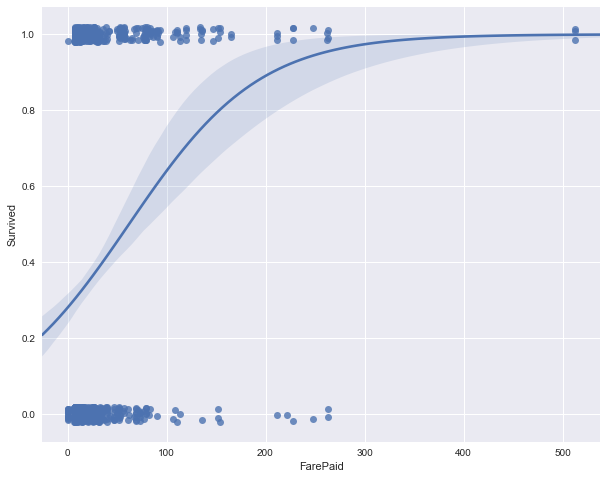

In [55]:
# Logistic regression visual
plt.figure(figsize=(10,8))
sns.regplot(data=df[['FarePaid','Survived']],x='FarePaid',y='Survived',logistic=True,y_jitter=0.02);

The plot of the logistic regression also shows the same pattern. I've added some jitter so we can more easily gauge density.

Below are the results of the test.

In [56]:
# For a single independent variable (FarePaid is only 1 column), 
#we must use reshape to ensure the fit() function can accept it as input
X = df['FarePaid'].values.reshape(-1, 1)
y = df['Survival'].values

# Splitting the data, 25% will be testing data and the other 75% will be training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=1)

# Running the regression
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

# Generate our predicted values
y_pred = LogReg.predict(X_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

To interpret our results we'll start with a confusion matrix. Below is the template of ours where we assign Survived as Positive.

In [57]:
# Typical Confusion Matrix
# Assigning Survived as True
tcm = [['Actual (row) / Predicted (col)','Died', 'Survived'],
      ['Died','True Negative','False Positive'],
      ['Survived','False Negative','True Positive']]
tbl.make_table(tcm)
tbl.set_global_style(align='center')
tbl.set_row_style(0, bold=True)
tbl.set_column_style(0, bold=True);
# tbl.set_cell_style(1,1, column_span=2);
# tbl.set_cell_style(0, 0, width=50,wrap=True);
# tbl.set_row_style(2,float_format='%0.3E');

In [58]:
tbl.render()

Actual (row) / Predicted (col),Died,Survived
Died,True Negative,False Positive
Survived,False Negative,True Positive


Our confusion matrix results.

In [59]:
# Confusion Matrix with labels, the sklearn cm function doesn't allow labels as easily
pd.crosstab(index=y_test,columns=y_pred,rownames=['Actual'],colnames=['Predicted'])
pd.crosstab(index=y_test,columns=y_pred,rownames=['Actual'],colnames=['Predicted'],normalize='index').round(2)

Predicted,Died,Survived
Actual,,
Died,118,10
Survived,78,17


Predicted,Died,Survived
Actual,,
Died,0.92,0.08
Survived,0.82,0.18


Looking at the values we find that predicting the deceased is good with 92% accuracy but predicting survivors is bad with 18% accuracy.

This leads to precision (aka specificity), recall (aka sensitivity) and the f1-score. We'll use these abbreviations: 
<br>TP = True Positive, FN = False Negative, etc.

**Precision** $= \frac{TP}{TP+FP}$

Precision is the ratio of correct positive predictions over the total positive predictions. Out of all predicted survivors, what percentage actually survived? Where 1 is perfect and 0 means none were predicted.

**Recall** $= \frac{TP}{TP+FN}$

Recall is the ratio of correct positive predictions over the total actual positive values. Out of all actual survivors, how many did we predict survived? Where 1 is perfect and 0 means none were predicted.

There is a natural trade off between precision and recall. If we wanted perfect recall for survivors, we can simply predict every passenger survived. We would have many False Positives (FP) but no False Negatives (FN) hence Recall would be 1. Knowing this we can use the F1-Score as a balanced metric of how our model, and in this case, how well our single variable (Fare Paid) will predict Survival.

<b>F1-Score</b> $= \frac{2\times(Recall\times Precision)}{Recall + Precision}$

F1-Score is the weighted average of Precision and Recall.

If we looked at no data, our average prediction rate should be 50%. A coin toss for Died or Survived. This gives us an idea of what a poor model should look like. If we use substitute 50% into our F1-Score formula, the output is also 50%.

Now we can read our classification report.

In [60]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

       Died       0.60      0.92      0.73       128
   Survived       0.63      0.18      0.28        95

avg / total       0.61      0.61      0.54       223



For our purposes I'm using the the average f1-score to gauge FarePaid as an indicator. Here we find it is 0.54. **Hence we conclude that Fare Paid is a poor indicator of survival as it's not much better than guessing (0.50).**

*Note: 'support' is the number of predictions.*

### Curiosity around Ticket Class and Fare Paid

Earlier we found that Ticket Class was a strong indicator of Survival, yet Fare Paid was a poor indicator. Normally we would think Ticket Class and Fare Paid should be correlated enough that Fare Paid might even be a redundant variable to be investigating. We will use a Pearson's R correlation test as well as a visualisation to illustrate why Fare Paid is not a good indicator of Surival unlike Ticket Class.

Assumptions:
- p-value of 0.05

In [61]:
# Checking correlation
pr, prPval = pearsonr(origdf['Fare'],origdf['Pclass'])
results = [['Item','Value'],
           ['Pearson\'s R Test',pr],
           ['P-Value', prPval]]
# setting up a nicer looking table.
tbl.make_table(results)
tbl.set_row_style(0, bold=True);
tbl.set_row_style(2,float_format='%0.3E');

In [62]:
tbl.render()

Item,Value
Pearson's R Test,-0.5495
P-Value,1.967E-71


Here we find a moderate negative relationship between Fare Paid and Ticket Class. Next we'll visualise the relationship, first grouping FarePaid.

In [63]:
# used this function when experimenting on bin size
intervSize = 20
def groupgen(bins):
    out = []
    for i in bins:
        if i < 520:
            out.append('{}-{}'.format(i,i+intervSize))
        else:
            return out

In [64]:
# Create bins and two new columns, AgeGroup
bins = list(range(0,300,intervSize))
bins[14] = 520

FarePaidGroups = groupgen(bins)
FarePaidGroups[13] = '260-520'

df['FarePaidGroup'] = pd.cut(df.FarePaid, bins, right=False, labels=FarePaidGroups).astype('object')

In [65]:
# Create our contingency table for visualising
ctFareClass = df[['FarePaidGroup','Class']].groupby(['FarePaidGroup','Class']).size().unstack(fill_value=0).reindex(FarePaidGroups,fill_value=0)
ctFareClass.head()

Class,First Class,Second Class,Third Class
FarePaidGroup,,,
0-20,6,104,405
20-40,64,70,66
40-60,38,3,13
60-80,32,7,7
80-100,23,0,0


In [66]:
# FarePaid vs Ticket Class
g = hc.Highcharts()

g.chart.type = 'column'
g.chart.zoomType = 'xy'
g.yAxis.title.text = '<b>Frequency</b>'
g.xAxis.title.text = '<b>Price Groups</b>'
g.xAxis.categories = list(ctFareClass.index)
# g.xAxis.labels.format = '£{point.x}'
# g.chart.height = 400
g.tooltip.headerFormat = '<b>£{point.x}</b><br>'
# g.tooltip.headerFormat = ''
# g.tooltip.pointFormat = 'Ticket Number {point.x}, Frequency {point.y}'
gpo = g.plotOptions.column
gpo.groupPadding = 0.05
gpo.pointPadding = 0
gpo.borderWidth = 1
gpo.showInLegend = True
g.tooltip.shared = 'True'
# gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'

g.title.text = 'Price Distribution by Ticket Class'
g.subtitle.text = '(drag-select to zoom)'
g.series = hc.build.series(ctFareClass, color={'First Class':'#434DF2', 'Second Class':'#EC4242', 'Third Class':'#B6B6B6'})


g.plot()

Here we see what we suspected, that the Fare Paid is not distributed as we would normally expect. We would expect First Class tickets to be concentrated at the higher prices, Second Class tickets to be concentrated in the middle and Third Class tickets to be concentrated at the lower prices.

Instead there are many tickets concentrated at lower prices and some First Class tickets at high prices. If we turn off First Class tickets we see that Second and Third class tickets are similarly distributed.

## Summary of factors

<table align="left" dir="ltr" style="width: 342px;" border="1" cellspacing="0" cellpadding="0"><colgroup><col width="145" /><col width="153" /><col width="153" /></colgroup>
<tbody>
<tr style="height: 21px;">
<td style="height: 21px; text-align: left; width: 266px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Independent Variable&quot;}"><strong>Independent Variable</strong></td>
<td style="height: 21px; text-align: left; width: 75px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Predictive Strength&quot;}"><strong>Predictive Strength</strong></td>
</tr>
<tr style="height: 21px;">
<td style="height: 21px; text-align: left; width: 266px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Gender (Categorical)&quot;}">Gender (Categorical)</td>
<td style="height: 21px; text-align: left; width: 75px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Strong&quot;}">Strong</td>
</tr>
<tr style="height: 21px;">
<td style="height: 21px; text-align: left; width: 266px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Age Groups (Interval)&quot;}">Age Groups (Interval)</td>
<td style="height: 21px; text-align: left; width: 75px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Weak&quot;}">Weak</td>
</tr>
<tr style="height: 21px;">
<td style="height: 21px; text-align: left; width: 266px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Ports (Categorical)&quot;}">Embarking Port (Categorical)</td>
<td style="height: 21px; text-align: left; width: 75px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Weak&quot;}">Weak</td>
</tr>
<tr style="height: 21px;">
<td style="height: 21px; text-align: left; width: 266px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Class (Ordinal)&quot;}">Ticket Class (Ordinal)</td>
<td style="height: 21px; text-align: left; width: 75px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Strong&quot;}">Strong</td>
</tr>
<tr style="height: 21px;">
<td style="height: 21px; text-align: left; width: 266px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;Fare Paid (Normal)&quot;}">Fare Paid (Normal)</td>
<td style="height: 21px; text-align: left; width: 75px;" data-sheets-value="{&quot;1&quot;:2,&quot;2&quot;:&quot;None&quot;}">Negligable</td>
</tr>
</tbody>
</table>

Now that we know Gender and Class are our two strongest factors, we will explore the combination of both versus Survival.

In [67]:
# Grouping Gender and Class
ctGC = df[['Gender','Class','Survival']].groupby(['Gender','Class','Survival']).size().unstack(fill_value=0)
ctGC

Survival             Died  Survived
Gender Class                       
Female First Class      3        91
       Second Class     6        70
       Third Class     72        72
Male   First Class     77        45
       Second Class    91        17
       Third Class    300        47

In [68]:
# Ticket Class and Gender combined.
g = hc.Highcharts()

g.chart.type = 'column'
g.yAxis.title.text = '<b>Percentage</b>'
g.yAxis.labels.format = '{value}%'
g.xAxis.title.text = '<b>Ticket Class</b>'
g.xAxis.categories = list(ctGC.index)
# g.chart.height = 400
# g.tooltip.headerFormat = '<b>{series.name}</b><br>'
g.tooltip.headerFormat = ''
# g.tooltip.pointFormat = '<b>{series.name}</b>: {point.percentage:.1f}%'
g.tooltip.pointFormat = '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.percentage:.1f}%)<br/>'
g.tooltip.shared = 'True'
gpo = g.plotOptions.column
gpo.stacking = 'percent'
# gpo.pointPadding = 0
# gpo.borderWidth = 1
gpo.showInLegend = True
# gpo.dataLabels.format = '{point.name}: {point.percentage:.1f}%'

# gpo.colors = ['#058DC7', '#50B432', '#33333']
# gpo.colorByPoint = True
# g.plotOptions.series.colorByPoint = True


g.title.text = 'Survival by Gender and Ticket Class'
g.series = hc.build.series(ctGC, color={'Died': 'black', 'Survived': 'green'})


g.plot()

Females in First and Second Class survived over 92% of the time, while a Female in Third Class still survived more frequently than any male.

### Does adding Age or Embarking Port give us more information?
I'm curious if adding one of our weak predictive variables (Age or Embarking Port) will lead to a deeper understanding. 

We will first group Gender and Class by Embarking Port, then group Gender and Class by Age Group.

In [69]:
# Adding Embarking Port
# df[['Gender','Class','EmbarkingPort','Survival']].groupby(['Gender','Class','EmbarkingPort','Survival']).size().unstack(fill_value=0)
pd.crosstab([df.Gender,df.Class,df.EmbarkingPort],df.Survival)

Survival                           Died  Survived
Gender Class        EmbarkingPort                
Female First Class  Cherbourg         1        42
                    Queenstown        0         1
                    Southampton       2        46
                    Unknown           0         2
       Second Class Cherbourg         0         7
                    Queenstown        0         2
                    Southampton       6        61
       Third Class  Cherbourg         8        15
                    Queenstown        9        24
                    Southampton      55        33
Male   First Class  Cherbourg        25        17
                    Queenstown        1         0
                    Southampton      51        28
       Second Class Cherbourg         8         2
                    Queenstown        1         0
                    Southampton      82        15
       Third Class  Cherbourg        33        10
                    Queenstown       36         3
                    Southampton     231        34

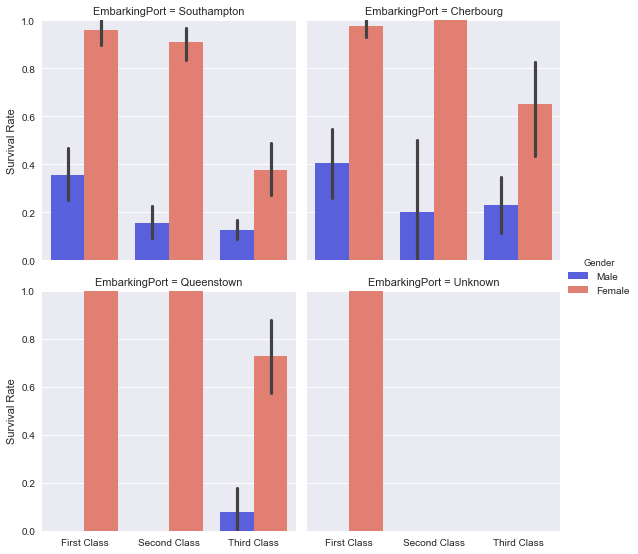

In [70]:
g = sns.factorplot(x='Class',y='Survived',hue='Gender', palette=['#434DF2','#F37161'],
               col='EmbarkingPort', order=['First Class','Second Class','Third Class'],
               data=df, kind='bar', col_wrap=2)
g.set_axis_labels('', 'Survival Rate')
g.set(ylim=(0, 1));

Visually we find nuances about each Embarking Port. The survival rate of men from highest to lowest Embarking the following: Cherbourg, Southhampton then Queenstown. Overall we don't gain much insight from adding Embarking Port.

Next we'll add Age Group instead of Embarking Port.

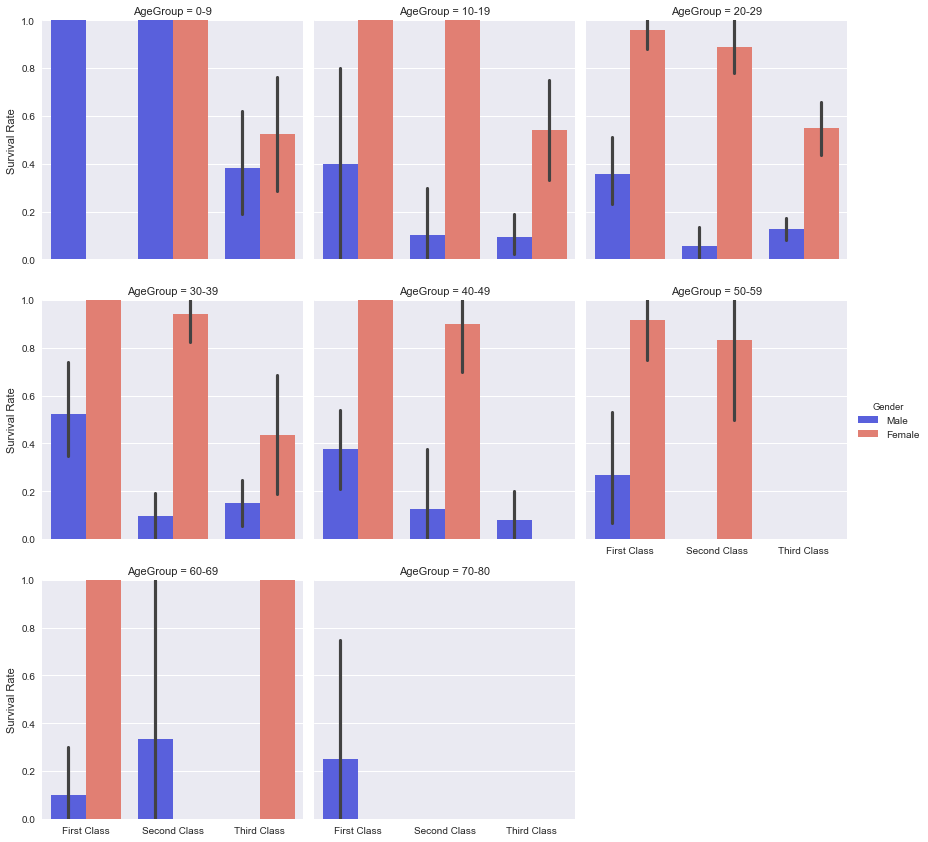

In [71]:
# Looking at Age Group 
g = sns.factorplot(x='Class',y='Survived',hue='Gender', palette=['#434DF2','#F37161'],
               col='AgeGroup', order=['First Class','Second Class','Third Class'],
               col_order=['0-9','10-19','20-29','30-39','40-49','50-59','60-69','70-80'],
               data=df, kind='bar', col_wrap=3)
g.set_axis_labels('', 'Survival Rate')
g.set(ylim=(0, 1));

We find two interesting insights. 
- Young (Age 0-9) Males in First and Second Class survived 100% of the time.
- Females in Third Class in most Age Groups survived significantly less than Females in First and Second Class.

***

## 4) Conclusion
In this notebook we explored five factors and determined which ones influenced survival aboard the Titanic as per the [Kaggle training dataset](https://www.kaggle.com/c/titanic/download/train.csv). 

To answer our question: **Which factors influence survival of a passenger?**

Gender and Ticket Class are strong influencing factors. 
<br>Age Groups and Embarking Ports are weak influencing factors. 
<br>Fare Paid is not an influencing factor.

Combinations of factors that lead to >90% survival rate:
- Females with First and Second Class Tickets
- Males with First and Second Class Tickets between Ages 0-9 years old.

### Limitations of our analysis
- Correlations found but these do not imply causation. We would need to run experiments to prove causation.
- Only used the Kaggle training dataset
- Using only 5 factors to conduct analysis


### Future work that would improve our findings:
- Find more data / datasets
- Test Factors that I choose not to explore (e.g. Name, Cabin, etc)
- Explore more combined factors
- Create a predictive model and test its results on [Kaggle](https://www.kaggle.com/c/titanic)

## References

[Pandas official documentation (various)](https://pandas.pydata.org/pandas-docs/stable/index.html) 2017

[Seaborn official documentation (various)](http://seaborn.pydata.org/) 2017

[Highcharts Options Reference](https://api.highcharts.com/highcharts/) 2017

[Stack Overflow Questions (various for Pandas,Seaborn)](https://stackoverflow.com/questions) 2017

[Cross Validated - Stack Exchange Questions (various for Statistics)](https://stats.stackexchange.com/) 2017

[Univerty of Toronto - Crosstabulation with Nominal Variables](http://groups.chass.utoronto.ca/pol242/Labs/LM-3A/LM-3A_content.htm) 2017

[NYU - Quantitative Analysis Guide: Choose Statistical Test for 1 Dependent Variable](https://guides.nyu.edu/quant/choose_test_1DV) 2017

[UCLA - CHOOSING THE CORRECT STATISTICAL TEST IN SAS, STATA, SPSS AND R](https://stats.idre.ucla.edu/other/mult-pkg/whatstat/) 2017



